In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

In [3]:
# Загрузка изображения в оттенках серого sar_3.jpg
image = cv2.imread('C:/ImageProcessing/labs/Binarization_Edges/sar_3.jpg')
if image is None:
    print("Изображение не найдено")
    exit()
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
# Нахождение наиболее протяженного участка дороги
blur = cv2.GaussianBlur(image_gray, (5, 5), 0)
canny = cv2.Canny(blur, 50, 150)
lines = cv2.HoughLines(canny, 1, np.pi / 180, threshold = 100)
image_lines = image.copy()

if lines is not None:
    longest_line = None
    max_length = 0
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        length = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        if length > max_length:
            max_length = length
            longest_line = (pt1, pt2)
    if longest_line:
        cv2.line(image_lines, longest_line[0], longest_line[1], (0, 0, 255), 7, cv2.LINE_AA)
else:
    print("Линий не обнаружено")

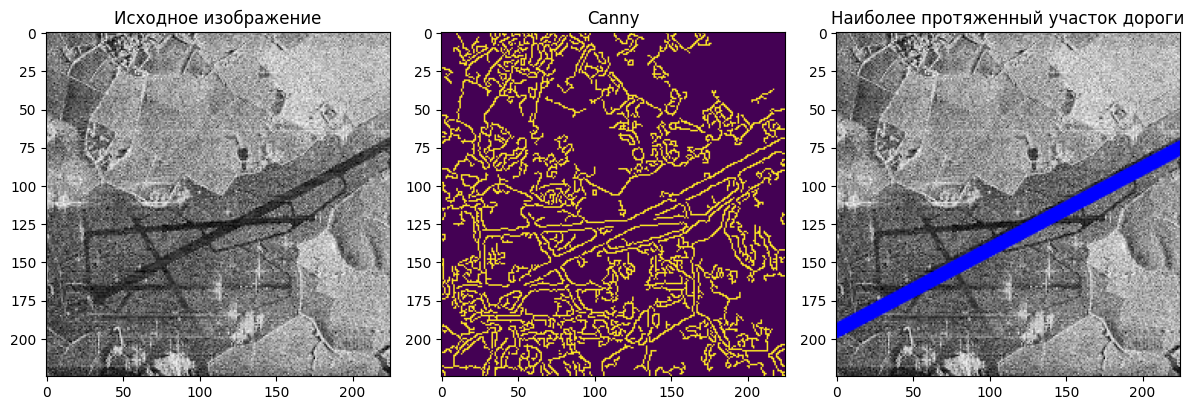

In [5]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')

plt.subplot(1, 3, 2)
plt.imshow(canny)
plt.title('Canny')

plt.subplot(1, 3, 3)
plt.imshow(image_lines)
plt.title('Наиболее протяженный участок дороги')

plt.tight_layout()
plt.show()

In [6]:
# Точечная бинаризация
bin_img = copy.deepcopy(image_gray)
T  = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

# Бинаризация Отсу
_,th2 = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Адаптивная бинаризация
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,71,21)

# Оператор Собеля
scale = 1
delta = 0
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(image_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(image_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5,0.0)

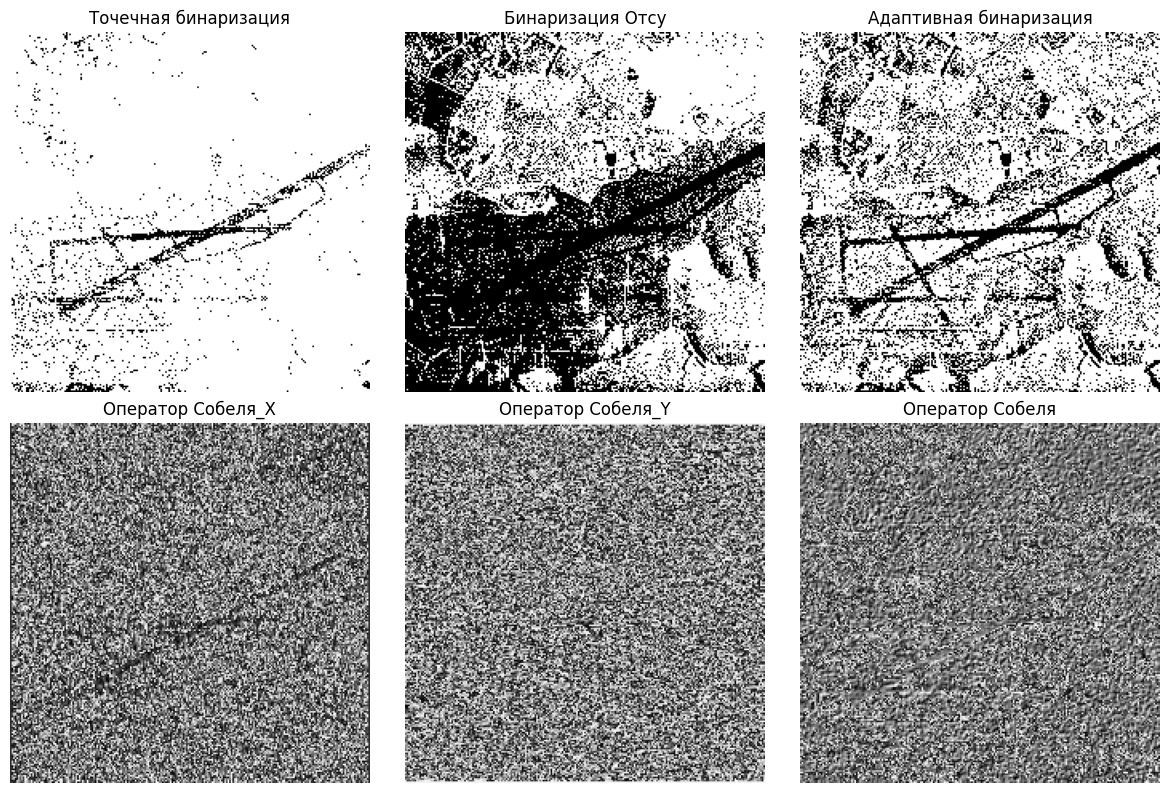

In [7]:
# Визуализация алгоритмов бинаризации
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(bin_img, cmap="gray")
plt.title('Точечная бинаризация')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(th2, cmap="gray")
plt.title('Бинаризация Отсу')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(th3, cmap="gray")
plt.title('Адаптивная бинаризация')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow((grad_x - grad_x.min())*255, cmap="gray")
plt.title('Оператор Собеля_X')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow((grad_y - grad_y.min())*255, cmap="gray")
plt.title('Оператор Собеля_Y')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow((grad - grad.min())*255, cmap="gray")
plt.title('Оператор Собеля')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Выделение участка дорожной полосы
blur = cv2.GaussianBlur(bin_img, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 55, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
line_image = image.copy()
if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            cv2.drawContours(line_image, [contour], -1, (0, 0, 255), 1)

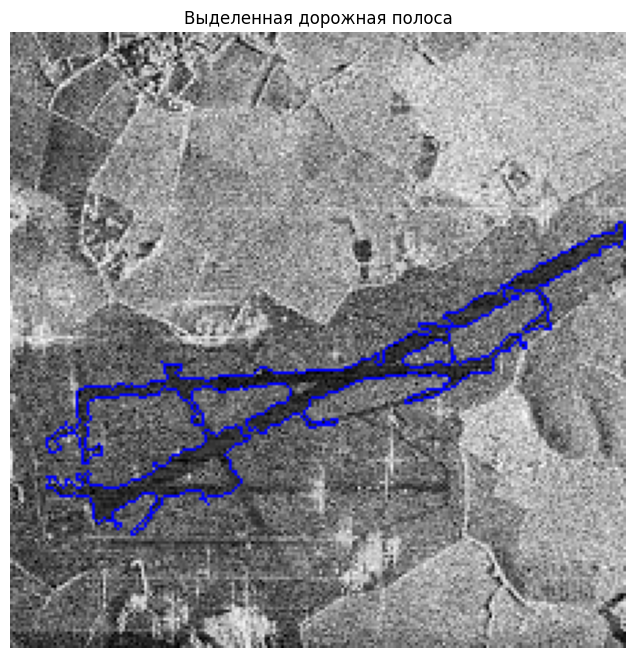

In [9]:
plt.figure(figsize=(12, 8))

plt.imshow(line_image, cmap="gray")
plt.title('Выделенная дорожная полоса')
plt.axis('off')
plt.show()